In [1]:
# Importing Libraries

import os
import sys
sys.path.append(".")
sys.path.append("..")

import pandas as pd
import numpy as np
import joblib

import nltk
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Set params

In [2]:
column_to_predict = "ticket_type"

classifier = "NB"
use_grid_search = True  # Grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = True  # Removes stop words from processed text
stop_words_lang = 'english'  # Used with 'remove_stop_words' and defines language of stop words collection
use_stemming = False  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ??
min_data_per_class = 1 # Used to determine number of samples required for each class. Classes with less than that will be excluded from the dataset. Default value is 1

In [3]:
dfTickets = pd.read_csv('endava_tickets.csv', header = 0, dtype=str)

## Select 'TEXT' column and remove poorly represented classes

In [4]:
text_columns = "description"  # "title" - text columns used for TF-IDF

# Removing rows related to classes represented by low amount of data
print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: " + str(dfTickets.shape))
print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: " + str(len(np.unique(dfTickets[column_to_predict]))))
bytag = dfTickets.groupby(column_to_predict).aggregate(np.count_nonzero)
tags = bytag[bytag.description > min_data_per_class].index
dfTickets = dfTickets[dfTickets[column_to_predict].isin(tags)]
print("Shape of dataset after removing classes with less then " + str(min_data_per_class) + " rows: " + str(dfTickets.shape))
print("Number of classes after removing classes with less then " + str(min_data_per_class) + " rows: " + str(len(np.unique(dfTickets[column_to_predict]))))

Shape of dataset before removing classes with less then 1 rows: (48549, 9)
Number of classes before removing classes with less then 1 rows: 2
Shape of dataset after removing classes with less then 1 rows: (48549, 9)
Number of classes after removing classes with less then 1 rows: 2


## Prepare data and labels and split them to train and test sets

In [5]:
labelData = dfTickets[column_to_predict]
data = dfTickets[text_columns]

# Split dataset into training and testing data in the ratio 80: 20
train_data, test_data, train_labels, test_labels = train_test_split(data, labelData, test_size=0.2)

# Extracting features from text

In [6]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [7]:
# Count vectorizer
if remove_stop_words:
    count_vect = CountVectorizer(stop_words=stop_words_lang)
elif use_stemming:
    count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
else:
    count_vect = CountVectorizer()

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(38839, 11361)

In [8]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(38839, 11361)

# Using pipeline to preprocess data and train classifier

In [9]:
# Fitting the training data into a data processing pipeline and eventually into the model itself
if classifier == "NB":
    print("Training NB classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’, ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([('vect', count_vect), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB(fit_prior=fit_prior))])
    text_clf = text_clf.fit(train_data, train_labels)

Training NB classifier


## Use GridSearchCV to search for best set of parameters

In [10]:
if use_grid_search:
    # Grid Search
    # Here, we are creating a list of parameters for which we would like to do performance tuning.
    # All the parameters name start with the classifier name (remember the arbitrary name we gave).
    # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

    # NB parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3)
    }

    # Next, we create an instance of the grid search by passing the classifier, parameters
    # and n_jobs=-1 which tells to use multiple cores from user machine.
    
    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(train_data, train_labels)

    # To see the best mean score and the params, run the following code
    gs_clf.best_score_
    gs_clf.best_params_

In [11]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

# Evaluate the model

In [12]:
print("Evaluating Model:")

# Score and evaluate model on test data using model without hyperparameter tuning
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

# Score and evaluate model on test data using model WITH hyperparameter tuning
if use_grid_search:
    predicted = gs_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix with GridSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean with GridSearch: " + str(prediction_acc))

Evaluating Model:
Confusion matrix without GridSearch:
[[2594  130]
 [  84 6902]]
Mean without GridSearch: 0.9779608650875387
Confusion matrix with GridSearch:
[[2667   57]
 [  89 6897]]
Mean with GridSearch: 0.9849639546858908


## Ploting confusion matrix

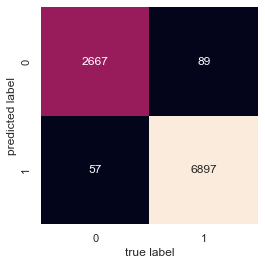

In [13]:
# Ploting confusion matrix with 'seaborn' module

mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show()

## Printing classification report

In [14]:
print(classification_report(test_labels, predicted,
                            target_names=np.unique(test_labels)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2724
           1       0.99      0.99      0.99      6986

    accuracy                           0.98      9710
   macro avg       0.98      0.98      0.98      9710
weighted avg       0.99      0.98      0.98      9710



In [15]:
# Save the best model
# joblib.dump(gs_clf, 'priority_model.jl')

['priority_model.jl']